In [1]:
import string
from unet1 import UNet
from testing_functions import *
from torchmetrics.image import StructuralSimilarityIndexMeasure
from testing_model import LightningModel
import warnings
from helper_functions import *
import matplotlib.pyplot as plt
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

In [2]:
warnings.filterwarnings('ignore')
dataset = '../Datasets/OADAT/swfd/SWFD_semicircle_RawBP-mini.h5'
input =  'sc,ss32_BP'
output = 'sc_BP'

# dataset = '../Datasets/OADAT/scd/SCD_RawBP-mini.h5'
# # input =  'vc,ss32_BP'
# # output = 'vc_BP'
# input ='ms,ss32_BP'
# output = "ms_BP"
# dataset = '../Datasets/OADAT/swfd/SWFD_multisegment_RawBP-mini.h5'
# input =  'ms,ss32_BP'
# output = 'ms_BP'
#
# dataset = '../Datasets/OADAT/msfd/MSFD_multisegment_RawBP-mini.h5'
# input =  'ms,ss32_BP_w780'
# output = 'ms_BP_w780'

In [3]:
model_pth_mouse='../final_model_weight/PAOmniNet/PA_OmniNet_Generalized.pth'

model_pth_Semi_Neuralizer= 'final_model_weight/PAOmniNet/PA_OmniNet_Generalized.pth'
model_pth_Multi_Neuralizer='final_model_weight/PAOmniNet/PA_OmniNet_Multi.pth'
model_pth_MFSD_Neuralizer=  'final_model_weight/PAOmniNet/PA_OmniNet_MSFD.pth'
model_pth_SCD_Neuralizer='final_model_weight/PAOmniNet/PA_OmniNet_SCD.pth'

model_pth_Semi_Unet= 'final_model_weight/Unet/Unet_Generalized.pth'
model_pth_Multi_Unet= 'final_model_weight/Unet/Unet_Multi.pth'
model_pth_MFSD_Unet= 'final_model_weight/Unet/Unet_MSFD.pth'
model_pth_SCD_Unet= 'final_model_weight/Unet/Unet_SCD.pth'

hparams = {
    "batch_size": 32,
    "learning_rate": 1e-4,
    "nb_levels": 4,
    "nb_inner_channels": 32,
    "nb_conv_layers_per_stage": 2,
    "data_slice_only": True,
    "max_epochs": 250,
}
Neuralizer_Semi = LightningModel(hparams)
state_dict = torch.load(model_pth_Semi_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_Semi.load_state_dict(state_dict)

Neuralizer_Multi = LightningModel(hparams)
state_dict = torch.load(model_pth_Multi_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_Multi.load_state_dict(state_dict)

Neuralizer_SCD = LightningModel(hparams)
state_dict = torch.load(model_pth_SCD_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_SCD.load_state_dict(state_dict)

Neuralizer_MFSD = LightningModel(hparams)
state_dict = torch.load(model_pth_MFSD_Neuralizer, map_location=torch.device('cpu'))
Neuralizer_MFSD.load_state_dict(state_dict)

Unet_Semi = UNet()
Unet_Semi.load_state_dict(torch.load(model_pth_Semi_Unet, map_location=torch.device('cpu')))
Unet_Semi.eval()

Unet_Multi = UNet()
Unet_Multi.load_state_dict(torch.load(model_pth_Multi_Unet, map_location=torch.device('cpu')))
Unet_Multi.eval()

Unet_SCD = UNet()
Unet_SCD.load_state_dict(torch.load(model_pth_SCD_Unet, map_location=torch.device('cpu')))
Unet_SCD.eval()

Unet_MFSD = UNet()
Unet_MFSD.load_state_dict(torch.load(model_pth_MFSD_Unet, map_location=torch.device('cpu')))
Unet_MFSD.eval()
print('Loaded')

Loaded


In [4]:
def preprocess_Unet(image, size=(256, 256)):
    image = (image - image.min()) / (image.max() - image.min())
    image = torch.tensor(image)
    image = image.unsqueeze(0)
    return image

def preprocess_batch_Unet(images, size=(256, 256)):
    processed_images = []
    for image in images:
        processed_image = preprocess_Unet(image, size)
        processed_images.append(processed_image)
    return torch.cat(processed_images, dim=0)


In [5]:
def get_all_test_data(dataset:str, input, output, CONTEXT_SIZE=16, idx_i=0):
    X, y = data_loader_formatter(dataset, input, output)
    X, y, context_in, context_out = creating_context(X, y, idx=idx_i, context_size = 16, random=False)
    X_Neuralizer = preprocess(X)
    y_Neuralizer = preprocess(y)
    X_Unet = preprocess_Unet(X)
    y_Unet = preprocess_Unet(y)
    context_in_preprocessed, context_out_preprocessed = preprocess_context(context_in, context_out)
    print(f'In this order:\nX_test_Neur = {X_Neuralizer.shape}, y_test_Neur = {y_Neuralizer.shape}, X_context = {context_in_preprocessed.shape}, y_context = {context_out_preprocessed.shape}\n'
          f'X_test_Unet = {X_Unet.shape}, y_test_Unet = {y_Unet.shape}')
    return X_Neuralizer, y_Neuralizer, context_in_preprocessed, context_out_preprocessed, X_Unet, y_Unet

In [6]:
idx = 3
X_Neuralizer_Semi, y_Neuralizer_Semi, X_context_Semi, y_context_Semi, X_unet_Semi, y_unet_Semi = get_all_test_data(dataset_semi, input_semi, output_semi, idx_i=idx)
X_Neuralizer_Multi, y_Neuralizer_Multi, X_context_Multi, y_context_Multi, X_unet_Multi, y_unet_Multi = get_all_test_data(dataset_multi, input_multi, output_multi, idx_i=14)
X_Neuralizer_SCD, y_Neuralizer_SCD, X_context_SCD, y_context_SCD, X_unet_SCD, y_unet_SCD = get_all_test_data(dataset_SCD, input_SCD, output_SCD, idx_i=6)
X_Neuralizer_MSFD, y_Neuralizer_MSFD, X_context_MSFD, y_context_MSFD, X_unet_MSFD, y_unet_MSFD = get_all_test_data(dataset_MSFD, input_MSFD, output_MSFD, idx_i=4)

In this order:
X_test_Neur = torch.Size([1, 3, 256, 256]), y_test_Neur = torch.Size([1, 3, 256, 256]), X_context = torch.Size([1, 16, 3, 256, 256]), y_context = torch.Size([1, 16, 3, 256, 256])
X_test_Unet = torch.Size([1, 256, 256]), y_test_Unet = torch.Size([1, 256, 256])
In this order:
X_test_Neur = torch.Size([1, 3, 256, 256]), y_test_Neur = torch.Size([1, 3, 256, 256]), X_context = torch.Size([1, 16, 3, 256, 256]), y_context = torch.Size([1, 16, 3, 256, 256])
X_test_Unet = torch.Size([1, 256, 256]), y_test_Unet = torch.Size([1, 256, 256])
In this order:
X_test_Neur = torch.Size([1, 3, 256, 256]), y_test_Neur = torch.Size([1, 3, 256, 256]), X_context = torch.Size([1, 16, 3, 256, 256]), y_context = torch.Size([1, 16, 3, 256, 256])
X_test_Unet = torch.Size([1, 256, 256]), y_test_Unet = torch.Size([1, 256, 256])
In this order:
X_test_Neur = torch.Size([1, 3, 256, 256]), y_test_Neur = torch.Size([1, 3, 256, 256]), X_context = torch.Size([1, 16, 3, 256, 256]), y_context = torch.Size([1,

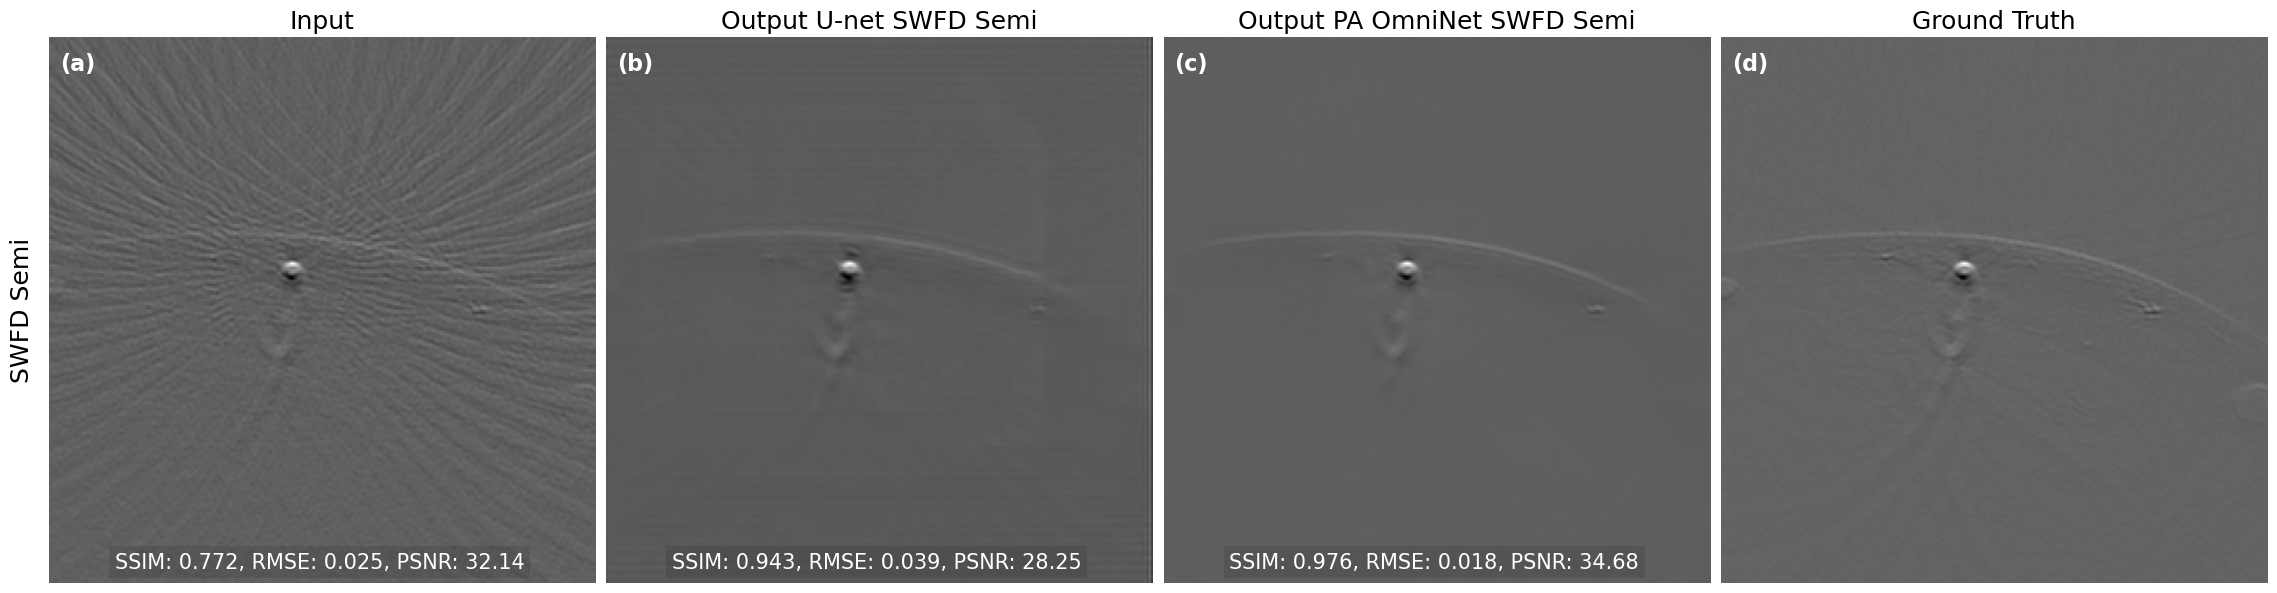

In [7]:
input_Unet = X_unet_Semi
input_Unet = input_Unet.float()
input_Unet = input_Unet.unsqueeze(0)
input_Unet = input_Unet.unsqueeze(0)
input_Neur = X_Neuralizer_Semi.unsqueeze(0)

ground_truth_Unet = y_unet_Semi
ground_truth_Unet = ground_truth_Unet.unsqueeze(0)
ground_truth_Unet = ground_truth_Unet.unsqueeze(0)
ground_truth_Neur = y_Neuralizer_Semi.unsqueeze(0)

output_Neur_Semi = Neuralizer_Semi.forward(input_Neur, X_context_Semi, y_context_Semi)
output_Neur_Semi =(output_Neur_Semi - output_Neur_Semi.min()) / (output_Neur_Semi.max() - output_Neur_Semi.min())
output_Unet_Semi = Unet_Semi(input_Unet.squeeze(0))
output_Unet_Semi = (output_Unet_Semi - output_Unet_Semi.min()) / (output_Unet_Semi.max() - output_Unet_Semi.min())

rmse_base_semi = compute_rmse(ground_truth_Neur, input_Neur)
psnr_base_semi = compute_psnr(ground_truth_Neur, input_Neur)
ssim_base_semi = ssim(ground_truth_Neur.squeeze(1), input_Neur.squeeze(1)).item()

rmse_neur_semi = compute_rmse(ground_truth_Neur.squeeze(0), output_Neur_Semi.squeeze(0))
psnr_neur_semi = compute_psnr(ground_truth_Neur.squeeze(0), output_Neur_Semi.squeeze(0))
ssim_neur_semi = ssim(ground_truth_Neur.squeeze(1), output_Neur_Semi).item()

rmse_unet_semi = compute_rmse(ground_truth_Unet, output_Unet_Semi)
psnr_unet_semi = compute_psnr(ground_truth_Unet, output_Unet_Semi)
ssim_unet_semi = ssim(ground_truth_Unet.squeeze(1), output_Unet_Semi).item()

input_show_semi = input_Unet.squeeze().cpu().detach().numpy()
output_show_semi = ground_truth_Unet.squeeze().cpu().detach().numpy()
outputimg_Neur_Semi = output_Neur_Semi.squeeze().permute(1, 2, 0).cpu().detach().numpy()
outputimg_Unet_Semi = output_Unet_Semi.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
titles = [
    f'Input',
    f'Output U-net SWFD Semi',f'Output PA OmniNet SWFD Semi',
    'Ground Truth']
images = [input_show_semi,outputimg_Unet_Semi, outputimg_Neur_Semi, output_show_semi]

plt.figure(figsize=(34, 12))

metrics = [
    f"SSIM: {ssim_base_semi:.3f}, RMSE: {rmse_base_semi:.3f}, PSNR: {psnr_base_semi:.2f}",
    f"SSIM: {ssim_unet_semi:.3f}, RMSE: {rmse_unet_semi:.3f}, PSNR: {psnr_unet_semi:.2f}",
#     f"SSIM: {ssim_specific:.3f}, RMSE: {rmse_specific:.3f}, PSNR: {psnr_specific:.2f}",
    f"SSIM: {ssim_neur_semi:.3f}, RMSE: {rmse_neur_semi:.3f}, PSNR: {psnr_neur_semi:.2f}",
#     f"SSIM: {ssim_val_neur_specific:.3f}, RMSE: {rmse_val_neur_specific:.3f}, PSNR: {psnr_val_neur_specific:.2f}",
    "Ground Truth",
]
alphabet = string.ascii_lowercase[:len(images)]
for idx, (title, img, metric, letter) in enumerate(zip(titles, images, metrics, alphabet)):
    ax = plt.subplot(1, 6, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    ax.text(0.02, 0.95, f"({letter})", fontsize=16, va='center', ha='left', color='white', fontweight='bold', transform=ax.transAxes)
    if idx == 0:
        ax.text(-.05, 0.5, 'SWFD Semi', fontsize=18, va='center', ha='center', rotation='vertical', transform=ax.transAxes)


    if idx < 6:
        plt.title(title, fontsize=18)

    if idx < len(metrics) and metrics[idx] != "Ground Truth":
        ax.text(0.12, 0.02, metrics[idx], fontsize=15, color="white",
                bbox=dict(facecolor='black', alpha=0.1, edgecolor='none'),
                va="bottom", ha="left", transform=ax.transAxes)

plt.subplots_adjust(left=0.01, right=0.99, top=0.85, bottom=0.15, wspace=0.02, hspace=0.01)
plt.show()



In [8]:
def get_row(X_Neuralizer, y_Neuralizer, context_in, context_out, X_Unet, y_Unet, Neur_specific, Unet_specific):
    input_Unet = X_Unet
    input_Unet = input_Unet.float()
    input_Unet = input_Unet.unsqueeze(0)
    input_Unet = input_Unet.unsqueeze(0)
    input_Neur = X_Neuralizer.unsqueeze(0)

    ground_truth_Unet = y_Unet
    ground_truth_Unet = ground_truth_Unet.unsqueeze(0)
    ground_truth_Unet = ground_truth_Unet.unsqueeze(0)
    ground_truth_Neur = y_Neuralizer.unsqueeze(0)

    output_Neur_Semi = Neuralizer_Semi.forward(input_Neur, context_in, context_out)
    output_Neur_Semi =(output_Neur_Semi - output_Neur_Semi.min()) / (output_Neur_Semi.max() - output_Neur_Semi.min())

    output_Neur_specific = Neur_specific.forward(input_Neur, context_in, context_out)
    output_Neur_specific = (output_Neur_specific - output_Neur_specific.min()) / (output_Neur_specific.max() - output_Neur_specific.min())

    output_Unet_Semi = Unet_Semi(input_Unet.squeeze(0))
    output_Unet_Semi = (output_Unet_Semi - output_Unet_Semi.min()) / (output_Unet_Semi.max() - output_Unet_Semi.min())

    output_Unet_specific = Unet_specific(input_Unet.squeeze(0))
    output_Unet_specific = (output_Unet_specific - output_Unet_specific.min()) / (output_Unet_specific.max() - output_Unet_specific.min())

    rmse_base = compute_rmse(ground_truth_Neur, input_Neur)
    psnr_base = compute_psnr(ground_truth_Neur, input_Neur)
    ssim_base = ssim(ground_truth_Neur.squeeze(1), input_Neur.squeeze(1)).item()
    baseline_metrics = [rmse_base, psnr_base, ssim_base]

    rmse_neur_semi = compute_rmse(ground_truth_Neur.squeeze(0), output_Neur_Semi.squeeze(0))
    psnr_neur_semi = compute_psnr(ground_truth_Neur.squeeze(0), output_Neur_Semi.squeeze(0))
    ssim_neur_semi = ssim(ground_truth_Neur.squeeze(1), output_Neur_Semi).item()
    PA_generalized_metrics = [rmse_neur_semi, psnr_neur_semi, ssim_neur_semi]

    rmse_neur_specific = compute_rmse(ground_truth_Neur.squeeze(0), output_Neur_specific.squeeze(0))
    psnr_neur_specific = compute_psnr(ground_truth_Neur.squeeze(0), output_Neur_specific.squeeze(0))
    ssim_neur_specific = ssim(ground_truth_Neur.squeeze(1), output_Neur_specific).item()
    PA_specific_metrics = [rmse_neur_specific, psnr_neur_specific, ssim_neur_specific]

    rmse_unet_semi = compute_rmse(ground_truth_Unet, output_Unet_Semi)
    psnr_unet_semi = compute_psnr(ground_truth_Unet, output_Unet_Semi)
    ssim_unet_semi = ssim(ground_truth_Unet.squeeze(1), output_Unet_Semi).item()
    Unet_generalized_metrics = [rmse_unet_semi, psnr_unet_semi, ssim_unet_semi]

    rmse_unet_specific = compute_rmse(ground_truth_Unet, output_Unet_specific)
    psnr_unet_specific = compute_psnr(ground_truth_Unet, output_Unet_specific)
    ssim_unet_specific = ssim(ground_truth_Unet.squeeze(1), output_Unet_specific).item()
    Unet_specific_metrics = [rmse_unet_specific, psnr_unet_specific, ssim_unet_specific]

    input_img = input_Unet.squeeze().cpu().detach().numpy()
    PA_generalized_img = output_Neur_Semi.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    PA_specific_img = output_Neur_specific.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    Unet_generalized_img = output_Unet_Semi.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    Unet_specific_img = output_Unet_specific.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    output_img = ground_truth_Unet.squeeze().cpu().detach().numpy()
    return input_img, Unet_generalized_img, Unet_specific_img, PA_generalized_img, PA_specific_img, output_img, [baseline_metrics, Unet_generalized_metrics, Unet_specific_metrics, PA_generalized_metrics, PA_specific_metrics]


<Figure size 3400x1800 with 0 Axes>

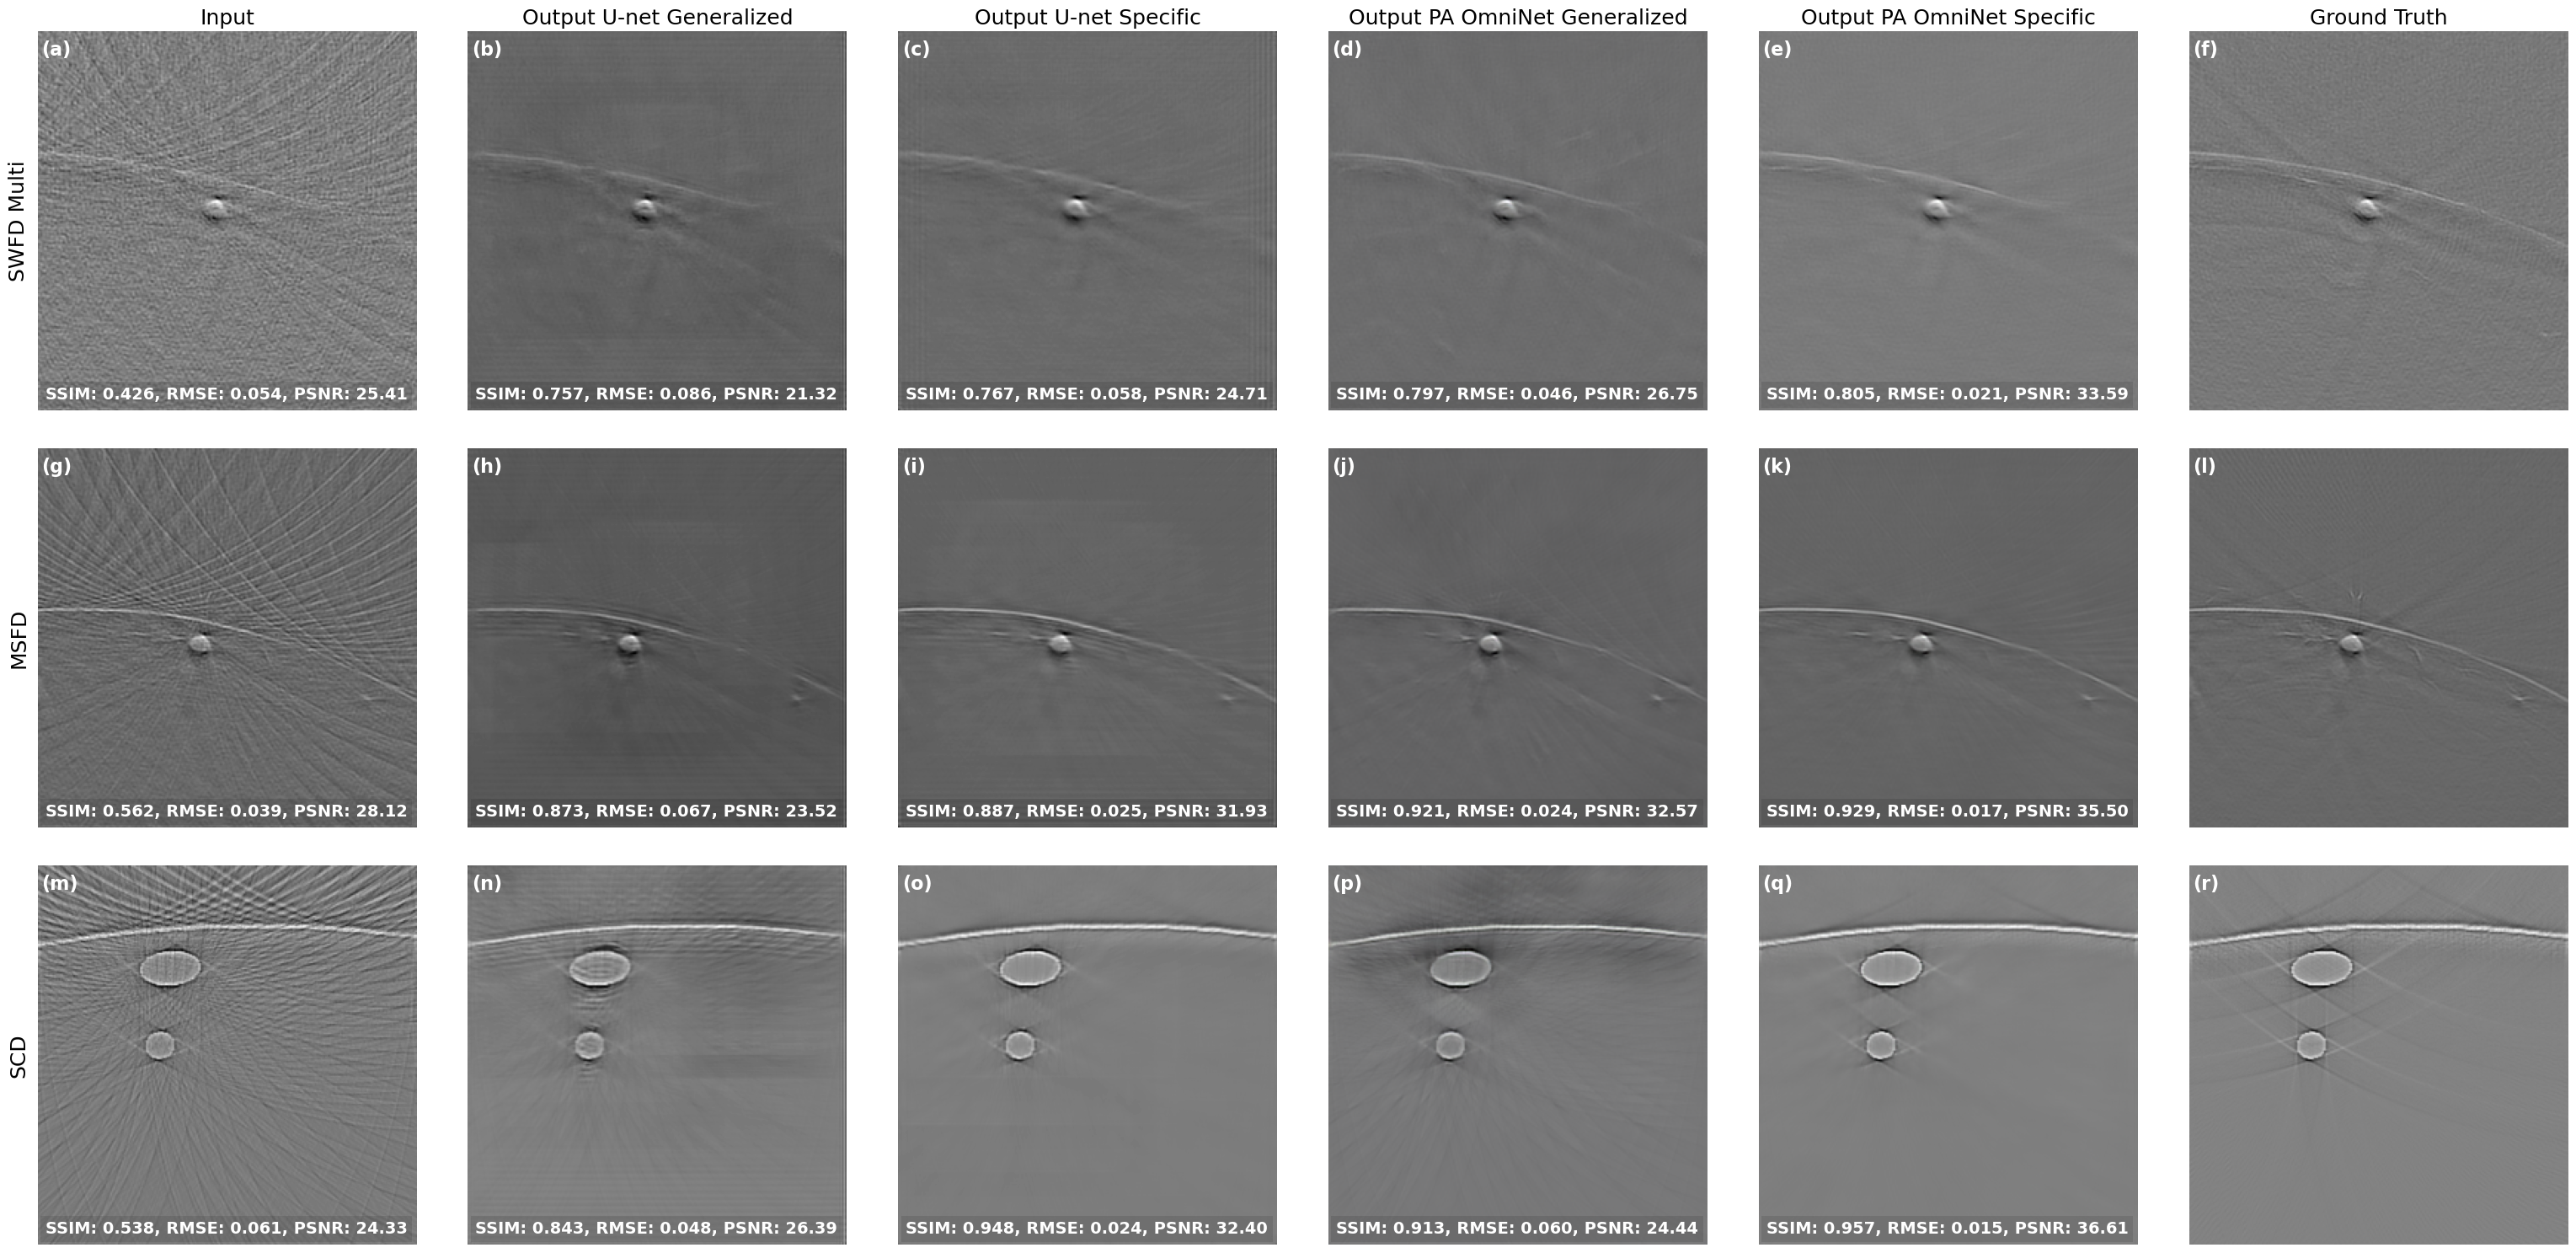

In [9]:

input_img_multi, Unet_generalized_img_multi, Unet_specific_img_multi, PA_generalized_img_multi, PA_specific_img_multi, output_img_multi, [baseline_metrics_multi, Unet_generalized_metrics_multi, Unet_specific_metrics_multi, PA_generalized_metrics_multi, PA_specific_metrics_multi] =(
    get_row(X_Neuralizer_Multi, y_Neuralizer_Multi, X_context_Multi, y_context_Multi, X_unet_Multi, y_unet_Multi, Neuralizer_Multi, Unet_Multi))

input_img_MSFD, Unet_generalized_img_MSFD, Unet_specific_img_MSFD, PA_generalized_img_MSFD, PA_specific_img_MSFD, output_img_MSFD, [baseline_metrics_MSFD, Unet_generalized_metrics_MSFD, Unet_specific_metrics_MSFD, PA_generalized_metrics_MSFD, PA_specific_metrics_MSFD] =(
    get_row(X_Neuralizer_MSFD, y_Neuralizer_MSFD, X_context_MSFD, y_context_MSFD, X_unet_MSFD, y_unet_MSFD, Neuralizer_MSFD, Unet_MSFD))

input_img_SCD, Unet_generalized_img_SCD, Unet_specific_img_SCD, PA_generalized_img_SCD, PA_specific_img_SCD, output_img_SCD, [baseline_metrics_SCD, Unet_generalized_metrics_SCD, Unet_specific_metrics_SCD, PA_generalized_metrics_SCD, PA_specific_metrics_SCD] =(
    get_row(X_Neuralizer_SCD, y_Neuralizer_SCD, X_context_SCD, y_context_SCD, X_unet_SCD, y_unet_SCD, Neuralizer_SCD, Unet_SCD))

titles = ['Input', 'Output U-net Generalized', 'Output U-net Specific', 'Output PA OmniNet Generalized', 'Output PA OmniNet Specific', 'Ground Truth']
images = [input_img_multi, Unet_generalized_img_multi, Unet_specific_img_multi, PA_generalized_img_multi, PA_specific_img_multi, output_img_multi,
          input_img_MSFD, Unet_generalized_img_MSFD, Unet_specific_img_MSFD, PA_generalized_img_MSFD, PA_specific_img_MSFD, output_img_MSFD,
          input_img_SCD, Unet_generalized_img_SCD, Unet_specific_img_SCD, PA_generalized_img_SCD, PA_specific_img_SCD, output_img_SCD]

plt.figure(figsize=(34, 18))

metrics = [
    f"SSIM: {baseline_metrics_multi[2]:.3f}, RMSE: {baseline_metrics_multi[0]:.3f}, PSNR: {baseline_metrics_multi[1]:.2f}",
    f"SSIM: {Unet_generalized_metrics_multi[2]:.3f}, RMSE: {Unet_generalized_metrics_multi[0]:.3f}, PSNR: {Unet_generalized_metrics_multi[1]:.2f}",
    f"SSIM: {Unet_specific_metrics_multi[2]:.3f}, RMSE: {Unet_specific_metrics_multi[0]:.3f}, PSNR: {Unet_specific_metrics_multi[1]:.2f}",
    f"SSIM: {PA_generalized_metrics_multi[2]:.3f}, RMSE: {PA_generalized_metrics_multi[0]:.3f}, PSNR: {PA_generalized_metrics_multi[1]:.2f}",
    f"SSIM: {PA_specific_metrics_multi[2]:.3f}, RMSE: {PA_specific_metrics_multi[0]:.3f}, PSNR: {PA_specific_metrics_multi[1]:.2f}",
    "Ground Truth",

    f"SSIM: {baseline_metrics_MSFD[2]:.3f}, RMSE: {baseline_metrics_MSFD[0]:.3f}, PSNR: {baseline_metrics_MSFD[1]:.2f}",
    f"SSIM: {Unet_generalized_metrics_MSFD[2]:.3f}, RMSE: {Unet_generalized_metrics_MSFD[0]:.3f}, PSNR: {Unet_generalized_metrics_MSFD[1]:.2f}",
    f"SSIM: {Unet_specific_metrics_MSFD[2]:.3f}, RMSE: {Unet_specific_metrics_MSFD[0]:.3f}, PSNR: {Unet_specific_metrics_MSFD[1]:.2f}",
    f"SSIM: {PA_generalized_metrics_MSFD[2]:.3f}, RMSE: {PA_generalized_metrics_MSFD[0]:.3f}, PSNR: {PA_generalized_metrics_MSFD[1]:.2f}",
    f"SSIM: {PA_specific_metrics_MSFD[2]:.3f}, RMSE: {PA_specific_metrics_MSFD[0]:.3f}, PSNR: {PA_specific_metrics_MSFD[1]:.2f}",
    "Ground Truth",

    f"SSIM: {baseline_metrics_SCD[2]:.3f}, RMSE: {baseline_metrics_SCD[0]:.3f}, PSNR: {baseline_metrics_SCD[1]:.2f}",
    f"SSIM: {Unet_generalized_metrics_SCD[2]:.3f}, RMSE: {Unet_generalized_metrics_SCD[0]:.3f}, PSNR: {Unet_generalized_metrics_SCD[1]:.2f}",
    f"SSIM: {Unet_specific_metrics_SCD[2]:.3f}, RMSE: {Unet_specific_metrics_SCD[0]:.3f}, PSNR: {Unet_specific_metrics_SCD[1]:.2f}",
    f"SSIM: {PA_generalized_metrics_SCD[2]:.3f}, RMSE: {PA_generalized_metrics_SCD[0]:.3f}, PSNR: {PA_generalized_metrics_SCD[1]:.2f}",
    f"SSIM: {PA_specific_metrics_SCD[2]:.3f}, RMSE: {PA_specific_metrics_SCD[0]:.3f}, PSNR: {PA_specific_metrics_SCD[1]:.2f}",
    "Ground Truth",
]

plt.figure(figsize=(34, 18))

alphabet = string.ascii_lowercase[:len(images)]
for idx, (img, metric, letter) in enumerate(zip(images, metrics, alphabet)):
    ax = plt.subplot(3, 6, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    ax.text(0.01, 0.95, f"({letter})", fontsize=16, va='center', ha='left', color='white', fontweight='bold', transform=ax.transAxes)

    if idx % 6 == 0:
        row_label = ['SWFD Multi', 'MSFD', 'SCD'][idx // 6]
        ax.text(-.05, 0.5, row_label, fontsize=18, va='center', ha='center', rotation='vertical', transform=ax.transAxes)

    if idx < 6:
        plt.title(titles[idx], fontsize=18)

    if metric != "Ground Truth":
        ax.text(0.02, 0.02, metric, fontsize=14, color="white",
                bbox=dict(facecolor='black', alpha=0.1, edgecolor='none'),
                va="bottom", ha="left", transform=ax.transAxes,  fontweight='bold')

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.01, hspace=0.1)
plt.show()
